In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

circuit = 'monza'

results_df = pd.read_csv(f'../data/driver-results-{circuit}.csv',)
driver_lap_data = pd.read_csv(f'../data/driver-lap-data-{circuit}.csv')

results_df

,number,driver,constructor,position,grid,year
0,10,farina,alfa,1,3,1950
1,48,serafini,ferrari,2,6,1950
2,48,ascari,ferrari,2,6,1950
3,36,fagioli,alfa,3,5,1950
4,58,rosier,lago,4,13,1950
...,...,...,...,...,...,...
1698,77,bottas,sauber,16,19,2024
1699,27,hulkenberg,haas,17,10,2024
1700,24,zhou,sauber,18,20,2024
1701,18,stroll,aston_martin,19,17,2024


# Starting Probability

Starting probability is expressed as follows: what is the likelihood of a given grid position to win the race. To caluclate this we will use the historical data dating back as far as we have data for. We then take all the winners (classified as position 1) and use an exponential function to model the probability dropoff after position 1. 

In [234]:
grid_res_df = results_df[results_df['position'] == 1]

grid_res_df

,number,driver,constructor,position,grid,year
0,10,farina,alfa,1,3,1950
29,2,ascari,ferrari,1,3,1951
52,12,ascari,ferrari,1,1,1952
76,50,fangio,maserati,1,2,1953
106,16,fangio,mercedes,1,1,1954
...,...,...,...,...,...,...
1603,10,gasly,alphatauri,1,10,2020
1623,3,ricciardo,mclaren,1,2,2021
1643,1,max_verstappen,red_bull,1,7,2022
1663,1,max_verstappen,red_bull,1,2,2023


<positron-console-cell-235>:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


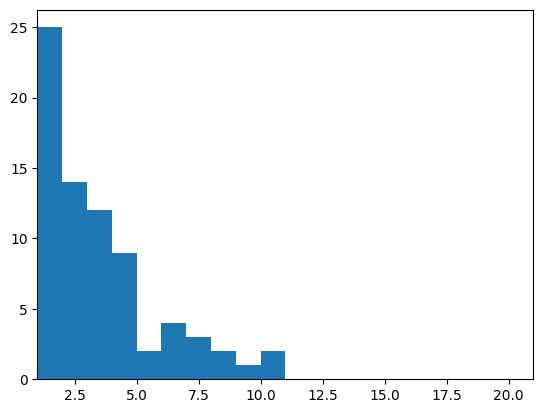

In [235]:
fig, ax = plt.subplots()

ax.hist(x = grid_res_df["grid"])

ax.set_xlim(1, 21)

fig.show()

In [236]:
data = grid_res_df['grid']

# Convert to DataFrame and count occurrences
df = pd.Series(data).value_counts().reset_index()

# Rename columns
df.columns = ['number', 'count']

# Sort by number (optional)
df = df.sort_values(by='number').reset_index(drop=True)

# Reindex to include 1 through 22, filling missing counts with 0
# df = df.reindex(range(1, 23), fill_value=0).reset_index()

# Create full index from 1 to 22
full_range = pd.DataFrame({'number': range(1, 21)})

# Merge with existing counts, filling missing with 0
merged_df = full_range.merge(df, on='number', how='left').fillna(0)

# Convert count to integer (optional, for clean output)
merged_df['count'] = merged_df['count'].astype(int)

merged_df['prob'] = merged_df['count'] / sum(merged_df['count'])

merged_df

,number,count,prob
0,1,25,0.337838
1,2,14,0.189189
2,3,12,0.162162
3,4,9,0.121622
4,5,2,0.027027
5,6,4,0.054054
6,7,3,0.040541
7,8,2,0.027027
8,9,1,0.013514
9,10,1,0.013514


Fitted model: y = 0.4870 * exp(-0.3995 * x)


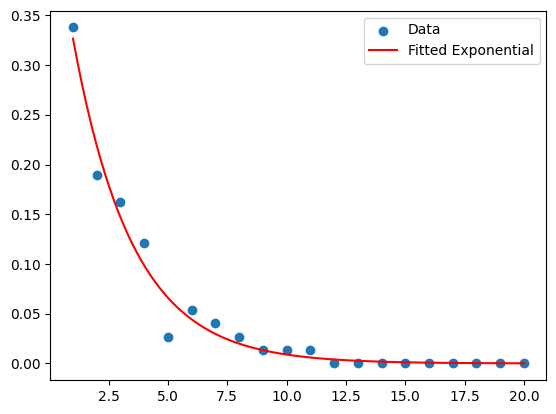

In [237]:
x = np.array(merged_df['number'])
y = np.array(merged_df['prob'])

# Exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

# Fit the curve
params, _ = curve_fit(exp_model, x, y, p0=(1, 1))

a, b = params
print(f"Fitted model: y = {a:.4f} * exp(-{b:.4f} * x)")

# Plot
x_fit = np.linspace(min(x), max(x), 100)
y_fit = exp_model(x_fit, a, b)

plt.scatter(x, y, label="Data")
plt.plot(x_fit, y_fit, color='red', label="Fitted Exponential")
plt.legend()
plt.show()

In [238]:
merged_df['exp'] = exp_model(merged_df['number'], a, b)
merged_df['exp'] = round(merged_df['exp'], 4)
merged_df['error'] = merged_df['exp'] - merged_df['prob']

merged_df

,number,count,prob,exp,error
0,1,25,0.337838,0.3266,-0.011238
1,2,14,0.189189,0.2191,0.029911
2,3,12,0.162162,0.1469,-0.015262
3,4,9,0.121622,0.0985,-0.023122
4,5,2,0.027027,0.0661,0.039073
5,6,4,0.054054,0.0443,-0.009754
6,7,3,0.040541,0.0297,-0.010841
7,8,2,0.027027,0.0199,-0.007127
8,9,1,0.013514,0.0134,-0.000114
9,10,1,0.013514,0.0090,-0.004514


In [239]:
output_df = pd.DataFrame({
    'circuit': [circuit for i in range(len(merged_df['number']))],
    'grid_pos': merged_df['number'],
    'starting_prob': merged_df['exp']
})

output_df

,circuit,grid_pos,starting_prob
0,monza,1,0.3266
1,monza,2,0.2191
2,monza,3,0.1469
3,monza,4,0.0985
4,monza,5,0.0661
5,monza,6,0.0443
6,monza,7,0.0297
7,monza,8,0.0199
8,monza,9,0.0134
9,monza,10,0.0090


# Probability Rate
The next step is to determine a base probability dropoff rate. This is a little more complicated to do with limited data, so we are going to try and simplify it. The way we are going to view this base rate is that if nothing else were to happen over the course of a lap, how would the probability change. This means we can make a couple of assumptions:
- If you are in first, your probability of winning will increase. Logically this makes sense as there are less laps for the drivers below first to catch you and overtake
- If you have some probability to start with, as the race goes on, the probability declines for each lap that you don't make a position, as you have less laps to gain a position
- If you don't have any probability to start with, your gain will be 0

Another thing to note is that as the race goes on the amount of probability you gain or lose should also increase or decrease as there are less laps to overtake. Lets start by mathematically modelling how much probability we gain or lose. 

<positron-console-cell-240>:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


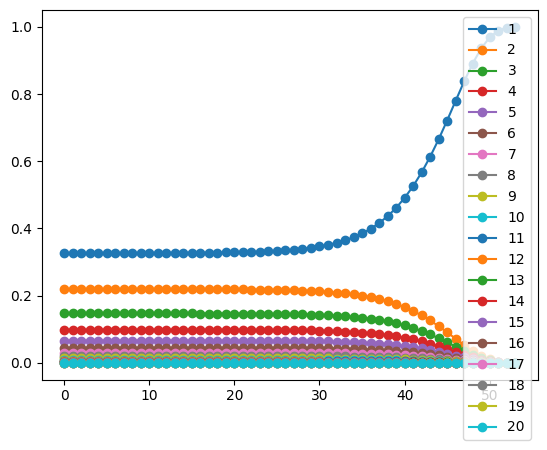

In [240]:
def probability_change(prob, lap, total_laps, target = 0, scale = 1.5):
    distance = target - prob if target > prob else prob - target
    decline_rate = scale **(total_laps - lap)
    decline_rate = 1 / decline_rate
    prob_change = distance * decline_rate
    return prob - prob_change if target == 0 else prob + prob_change

fig, ax = plt.subplots()

for index, row in output_df.iterrows():
    total_laps = int(max(driver_lap_data['lap']))
    x = [0]
    y = [row['starting_prob']]

    for i in range(1, total_laps + 1):
        change = probability_change(y[i - 1], i, total_laps, 1 if row['grid_pos'] == 1 else 0, scale=1.25)
        x.append(i)
        y.append(change)

    ax.plot(x, y, linestyle="-", marker="o", label = row['grid_pos'])

ax.legend()
fig.show()

Now that we have our base rates, to help with processing speeds, we are going to store this data in a dataframe to pull from later.

In [241]:
laps = int(max(driver_lap_data['lap']))
data = []

for index, row in output_df.iterrows():
    x = [0]
    y = [row['starting_prob']]

    data.append({
        'circuit': circuit,
        'position': row['grid_pos'],
        'lap_number': 0,
        'state': row['starting_prob']
    })

    for i in range(1, total_laps + 1):
        change = probability_change(y[i - 1], i, total_laps, 1 if row['grid_pos'] == 1 else 0)
        x.append(i)
        y.append(change)
        data.append({
            'circuit': circuit,
            'position': row['grid_pos'],
            'lap_number': i,
            'state': change
        })

base_state_df = pd.DataFrame(data = data)

base_state_df

,circuit,position,lap_number,state
0,monza,1,0,0.326600
1,monza,1,1,0.326600
2,monza,1,2,0.326600
3,monza,1,3,0.326600
4,monza,1,4,0.326600
...,...,...,...,...
1075,monza,20,49,0.000106
1076,monza,20,50,0.000075
1077,monza,20,51,0.000042
1078,monza,20,52,0.000014


Lets take a look at a driver's race from Monza and how their win probability changed

In [242]:
from matplotlib.ticker import MultipleLocator

driver_id = 'max_verstappen'
race_year = 2023
sample_data = driver_lap_data[(driver_lap_data['year'] == race_year) & (driver_lap_data['driver_id'] == driver_id)]

def create_win_probability(data):
    new_df = data.copy()
    new_df.to_records()

    prob_data = []

    lap_col = 5
    pos_col = 6

    for row in sample_data.to_records():
        lap = row[lap_col]
        position = row[pos_col]

        new_prob = base_state_df[(base_state_df['lap_number'] == lap) & (base_state_df['position'] == position)]['state']

        if (len(new_prob) == 0):
            prob_data.append(0)
        else:
            prob_data.append(new_prob)

    new_df['prob'] = prob_data

    return new_df

prob_data = create_win_probability(sample_data)

def show_win_prob_graph(data):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 5))

    ax1.plot(data["lap"], data["position"])
    ax1.yaxis.set_major_locator(MultipleLocator(1))
    ax1.set_ylim(0, 20)
    ax1.invert_yaxis()

    ax2.plot(data['lap'], data['prob'])
    ax2.set_ylim(0, 1)

    fig.show()

prob_data
# show_win_prob_graph(prob_data)

,year,driver_num,driver_id,circuit,lap,position,net_gain,prob
4707,2023,1,max_verstappen,monza,1.0,3.0,68.227222,"109 0.1469 Name: state, dtype: float64"
4708,2023,1,max_verstappen,monza,2.0,2.0,20.381667,"56 0.2191 Name: state, dtype: float64"
4709,2023,1,max_verstappen,monza,3.0,2.0,-11.136944,"57 0.2191 Name: state, dtype: float64"
4710,2023,1,max_verstappen,monza,4.0,2.0,14.098889,"58 0.2191 Name: state, dtype: float64"
4711,2023,1,max_verstappen,monza,5.0,2.0,-13.810000,"59 0.2191 Name: state, dtype: float64"
4712,2023,1,max_verstappen,monza,6.0,2.0,27.349444,"60 0.2191 Name: state, dtype: float64"
4713,2023,1,max_verstappen,monza,7.0,2.0,6.278611,"61 0.2191 Name: state, dtype: float64"
4714,2023,1,max_verstappen,monza,8.0,2.0,-19.400000,"62 0.2191 Name: state, dtype: float64"
4715,2023,1,max_verstappen,monza,9.0,2.0,21.938056,"63 0.2191 Name: state, dtype: float64"
4716,2023,1,max_verstappen,monza,10.0,2.0,13.470000,"64 0.2191 Name: state, dtype: float64"


# First Event: Gap Gain/Loss